# GAN exploration

In [3]:
# Class exercice
class polygon(): 
    def __init__(self, sides, name):
        self.sides = sides
        self.name = name

square = polygon(4, "Square")
pentagon = polygon(5, "Pentagon")
print(square.sides)

4


# Dataset idea 

### TIME GAN
Generating synthetic data apple stock using GAN
https://www.kaggle.com/code/faaizhashmi/generating-synthetic-data-apple-stock-using-gan

### Medical Image Generation with GANs
kaggle.com/code/asif00/medical-image-generation-with-gans 

### GAN-On Tabular Data
https://www.kaggle.com/code/samanemami/gan-on-tabular-data

### TTS-GAN
https://www.kaggle.com/code/fluentn/tts-gan/data

# Framework 
#### 1st GAN 
1. Generator
2. Discriminator 
3. Loss function of the discriminator 
4. Training 

Get comfortable with the classes and how we call it 
Practice different training techniques and highlight the limitations of the GAN build 

In [32]:
# Import the required librairies 
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms, datasets
from torchvision.datasets import MNIST # Training dataset
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
torch.manual_seed(0) # Set for testing purposes, please do not change!

In [27]:
#initially I went for 128*128, later decided to go with 512*512 image size
BUFFER_SIZE = 64000
BATCH_SIZE = 64
EPOCHS = 50
latent_dim = 64
input_size = [128*2, 128*2, 3]
image_size = (28*2, 28*2)

In [36]:
image_directory = '/Users/philippebeliveau/Desktop/Notebook_Jupyter_R/Synthetic_Data/GAN/chest_xray/train'

def filter_classes(file):
    # Liste des classes que vous voulez charger
    classes = ['NORMAL', 'PNEUMONIA']
    
    # Vérifier si le fichier appartient à l'une des classes spécifiées
    return any(cls in file for cls in classes)

# Définir les transformations à appliquer sur les images
# Vous pouvez ajouter d'autres transformations ici si nécessaire
transform = transforms.Compose([
    transforms.Resize((image_size)),  # Redimensionner les images
    transforms.ToTensor(),  # Convertir les images en tenseurs
])


# Utiliser ImageFolder pour charger les images à partir du répertoire
dataset = datasets.ImageFolder(image_directory, transform=transform, is_valid_file=filter_classes)

# Utiliser DataLoader pour gérer le chargement des données en lots
train_dataloader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

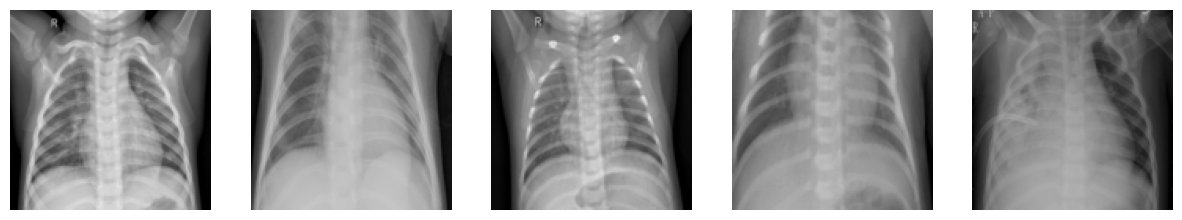

In [35]:
import matplotlib.pyplot as plt

# Obtenir un lot de données
images, labels = next(iter(train_dataloader))

# Afficher les premières images du lot
fig, axs = plt.subplots(1, 5, figsize=(15, 3))  # Créer une figure avec 5 subplots
for i in range(5):  # Afficher les 5 premières images
    axs[i].imshow(images[i].permute(1, 2, 0))  # Les images sont chargées en format (C, H, W), donc nous devons les permuter pour les afficher
    axs[i].axis('off')  # Supprimer les axes

plt.show()

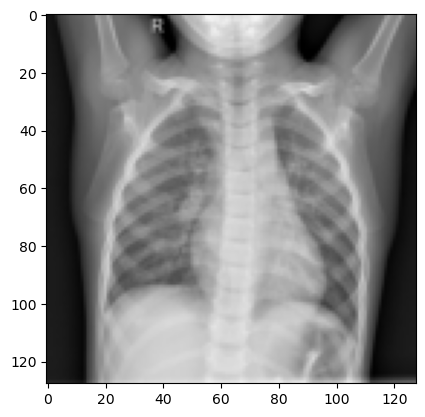

In [37]:
def get_images_of_class(dataloader, class_name):
    # Obtenir l'index de la classe
    class_index = dataloader.dataset.class_to_idx[class_name]
    
    # Filtrer les images de cette classe
    images_of_class = [image for image, label in dataloader.dataset if label == class_index]
    
    return images_of_class

# Obtenir toutes les images de la classe 'NORMAL'
normal_images = get_images_of_class(train_dataloader, 'NORMAL')

# Afficher la première image de la classe 'NORMAL'
plt.imshow(normal_images[0].permute(1, 2, 0))

# Generator

Build a Deep convolutional GAN 
- Use convolutions without any pooling layers
- Use batchnorm in both the generator and the discriminator
- Don't use fully connected hidden layers
- Use ReLU activation in the generator for all layers except for the output, which uses a Tanh activation.
- Use LeakyReLU activation in the discriminator for all layers except for the output, which does not use an activation

In [42]:
class Generator(nn.Module): 
    '''
    Generator Class 
        z_dim: the dimension of the noise vector, a scalar
        im_chan: the number of channels of the output image, a scalar
        (MNIST is black-and-white, so 1 channel is your default)
        hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, z_dim=10, im_chan = 1, hidden_dim = 64): 
        super(Generator, self).__init__()
        self.z_dim = z_dim 
        # Build the neural network 
        self.gen = self.gen_block(z_dim, hidden_dim*4)
        self.gen = self.gen_block(hidden_dim*4, hidden_dim*2)
        self.gen = self.gen_block(hidden_dim*2, hidden_dim)
        self.gen = self.gen_block(hidden_dim, im_chan, final_layer = True)

    def gen_block(self, in_channels, out_channels, kernel_size= 3, stride= 2, batch_norm = True, final_layer = False): 
        if not final_layer: 
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size, stride, bias = False), 
                nn.BatchNorm2d(out_channels), 
                nn.ReLU(inplace = True)
            )
        else: 
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size, stride, bias = False), 
                nn.Tanh(inplace = True)
            )


In [40]:
class Discriminator(nn.Module): 
    def __init__(self, z_dim=10, im_chan = 1, hidden_dim = 64): 
        super(Generator, self).__init__()
        self.z_dim = z_dim 
        # Build the neural network 
        self.gen = self.gen_block(z_dim, hidden_dim*4)
        self.gen = self.gen_block(hidden_dim*4, hidden_dim*2)
        self.gen = self.gen_block(hidden_dim*2, hidden_dim)
        self.gen = self.gen_block(hidden_dim, im_chan, final_layer = True)

    def disc_block(self, in_channels, out_channels, kernel_size= 3, stride= 2, batch_norm = True, final_layer = False): 
        if not final_layer: 
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size, stride, bias = False), 
                nn.BatchNorm2d(out_channels), 
                nn.ReLU(inplace = True)
            )
        else: 
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size, stride, bias = False), 
                nn.Tanh(inplace = True)
            )

In [41]:
class GAN(nn.Module): 
    def __init__(self, z_dim, im_chan, hidden_dim): 
        super(GAN, self).__init__()
        self.z_dim = z_dim
        self.im_chan = im_chan
        self.hidden_dim = hidden_dim
        self.gen = Generator(z_dim, im_chan, hidden_dim)
        self.disc = Discriminator(z_dim, im_chan, hidden_dim)
        self.gen_opt = torch.optim.Adam(self.gen.parameters(), lr = 0.0002, betas = (0.5, 0.999))
        self.disc_opt = torch.optim.Adam(self.disc.parameters(), lr = 0.0002, betas = (0.5, 0.999))
        self.criterion = nn.BCELoss()
        self.disc_losses = []
        self.gen_losses = []
        self.num_steps = 0

    def get_disc(self): 
        return self.disc

    def get_gen(self): 
        return self.gen

    def get_disc_opt(self): 
        return self.disc_opt

    def get_gen_opt(self): 
        return self.gen_opt

    def get_disc_loss(self): 
        return self.disc_losses

    def get_gen_loss(self): 
        return self.gen_losses

    def get_num_steps(self): 
        return self.num_steps

    def set_disc(self, disc): 
        self.disc = disc

    def set_gen(self, gen): 
        self.gen = gen

    def set_disc_opt(self, disc_opt): 
        self.disc_opt = disc_opt

    def set_gen_opt(self, gen_opt): 
        self.gen_opt = gen_opt

    def set_disc_loss(self, disc_losses): 
        self.disc_losses = disc_losses

    def set_gen_loss(self, gen_losses): 
        self.gen_losses = gen_losses

    def set_num_steps(self, num_steps): 
        self.num_steps = num_steps

    def train_step(self, real_images): 
        batch_size = real_images.size(0)
        criterion = self.criterion

        # Generate fake images
        fake_images = self.gen(real_images)

        # Train the discriminator
        disc_opt = self.disc_opt
        disc_opt.zero_grad()
        disc_fake_pred = self.disc(fake_images.detach())
        disc_fake_loss = criterion(disc_fake_pred, torch.zeros_like(disc_fake_pred))
        disc_real_pred = self.disc(real_images)
        disc

AttributeError: type object 'Discriminator' has no attribute 'summary'